In [4]:
import sys

sys.path.append("../")

import MetaTrader5 as mt5
import pytz
import numpy as np
import pandas_ta as ta
import pandas as pd

from datetime import datetime
from terminal.Extensions.Mt5Helper import Mt5Helper
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import metrics

from sklearn.metrics import classification_report

In [5]:
mt5.initialize()

True

In [34]:
slippage = 5
days = [17, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31]
data_list = []
for day in days: 
    from_date = datetime(2024, 5, day, tzinfo=pytz.utc)
    to_date = datetime(
        from_date.year, from_date.month, from_date.day, hour=23, tzinfo=pytz.utc
    )
    data_list.append(mt5.copy_ticks_range("WINM24", from_date, to_date, mt5.COPY_TICKS_TRADE))

In [222]:
trainrates = pd.DataFrame()
for data in data_list: 
    trainrates = pd.concat([trainrates, Mt5Helper.OHLC(data, "5s")])
trainrates

,open,high,low,close,tick_volume,real_volume
time_msc,,,,,,
2024-05-17 09:00:30+00:00,129350.0,129360.0,129325.0,129350.0,1494,8302
2024-05-17 09:00:35+00:00,129325.0,129375.0,129080.0,129235.0,5963,20319
2024-05-17 09:00:40+00:00,129230.0,129280.0,129150.0,129185.0,3354,10394
2024-05-17 09:00:45+00:00,129180.0,129270.0,129175.0,129220.0,3396,10848
2024-05-17 09:00:50+00:00,129220.0,129280.0,129220.0,129240.0,1844,5185
...,...,...,...,...,...,...
2024-05-31 18:31:00+00:00,NaN,NaN,NaN,NaN,0,0
2024-05-31 18:31:05+00:00,NaN,NaN,NaN,NaN,0,0
2024-05-31 18:31:10+00:00,NaN,NaN,NaN,NaN,0,0


,open,high,low,close,tick_volume,real_volume,sma,current_delta,forecast_delta,current_score,forecast_score
open,1.000000,0.999993,0.999992,0.999985,0.062052,0.059896,0.349295,0.009075,0.007649,0.014574,0.015344
high,0.999993,1.000000,0.999988,0.999992,0.063737,0.061518,0.348743,0.008863,0.008207,0.014854,0.015179
low,0.999992,0.999988,1.000000,0.999992,0.060068,0.057926,0.349899,0.009108,0.008501,0.014457,0.014732
close,0.999985,0.999992,0.999992,1.000000,0.061789,0.059594,0.349348,0.008900,0.009008,0.014705,0.014584
tick_volume,0.062052,0.063737,0.060068,0.061789,1.000000,0.982658,-0.125601,-0.073738,-0.082421,0.099327,0.108858
real_volume,0.059896,0.061518,0.057926,0.059594,0.982658,1.000000,-0.105682,-0.077480,-0.088491,0.100335,0.111027
sma,0.349295,0.348743,0.349899,0.349348,-0.125601,-0.105682,1.000000,-0.001303,-0.001766,-0.032707,-0.032460
current_delta,0.009075,0.008863,0.009108,0.008900,-0.073738,-0.077480,-0.001303,1.000000,0.900504,-0.570933,-0.515100
forecast_delta,0.007649,0.008207,0.008501,0.009008,-0.082421,-0.088491,-0.001766,0.900504,1.000000,-0.513593,-0.570933
current_score,0.014574,0.014854,0.014457,0.014705,0.099327,0.100335,-0.032707,-0.570933,-0.513593,1.000000,0.509053


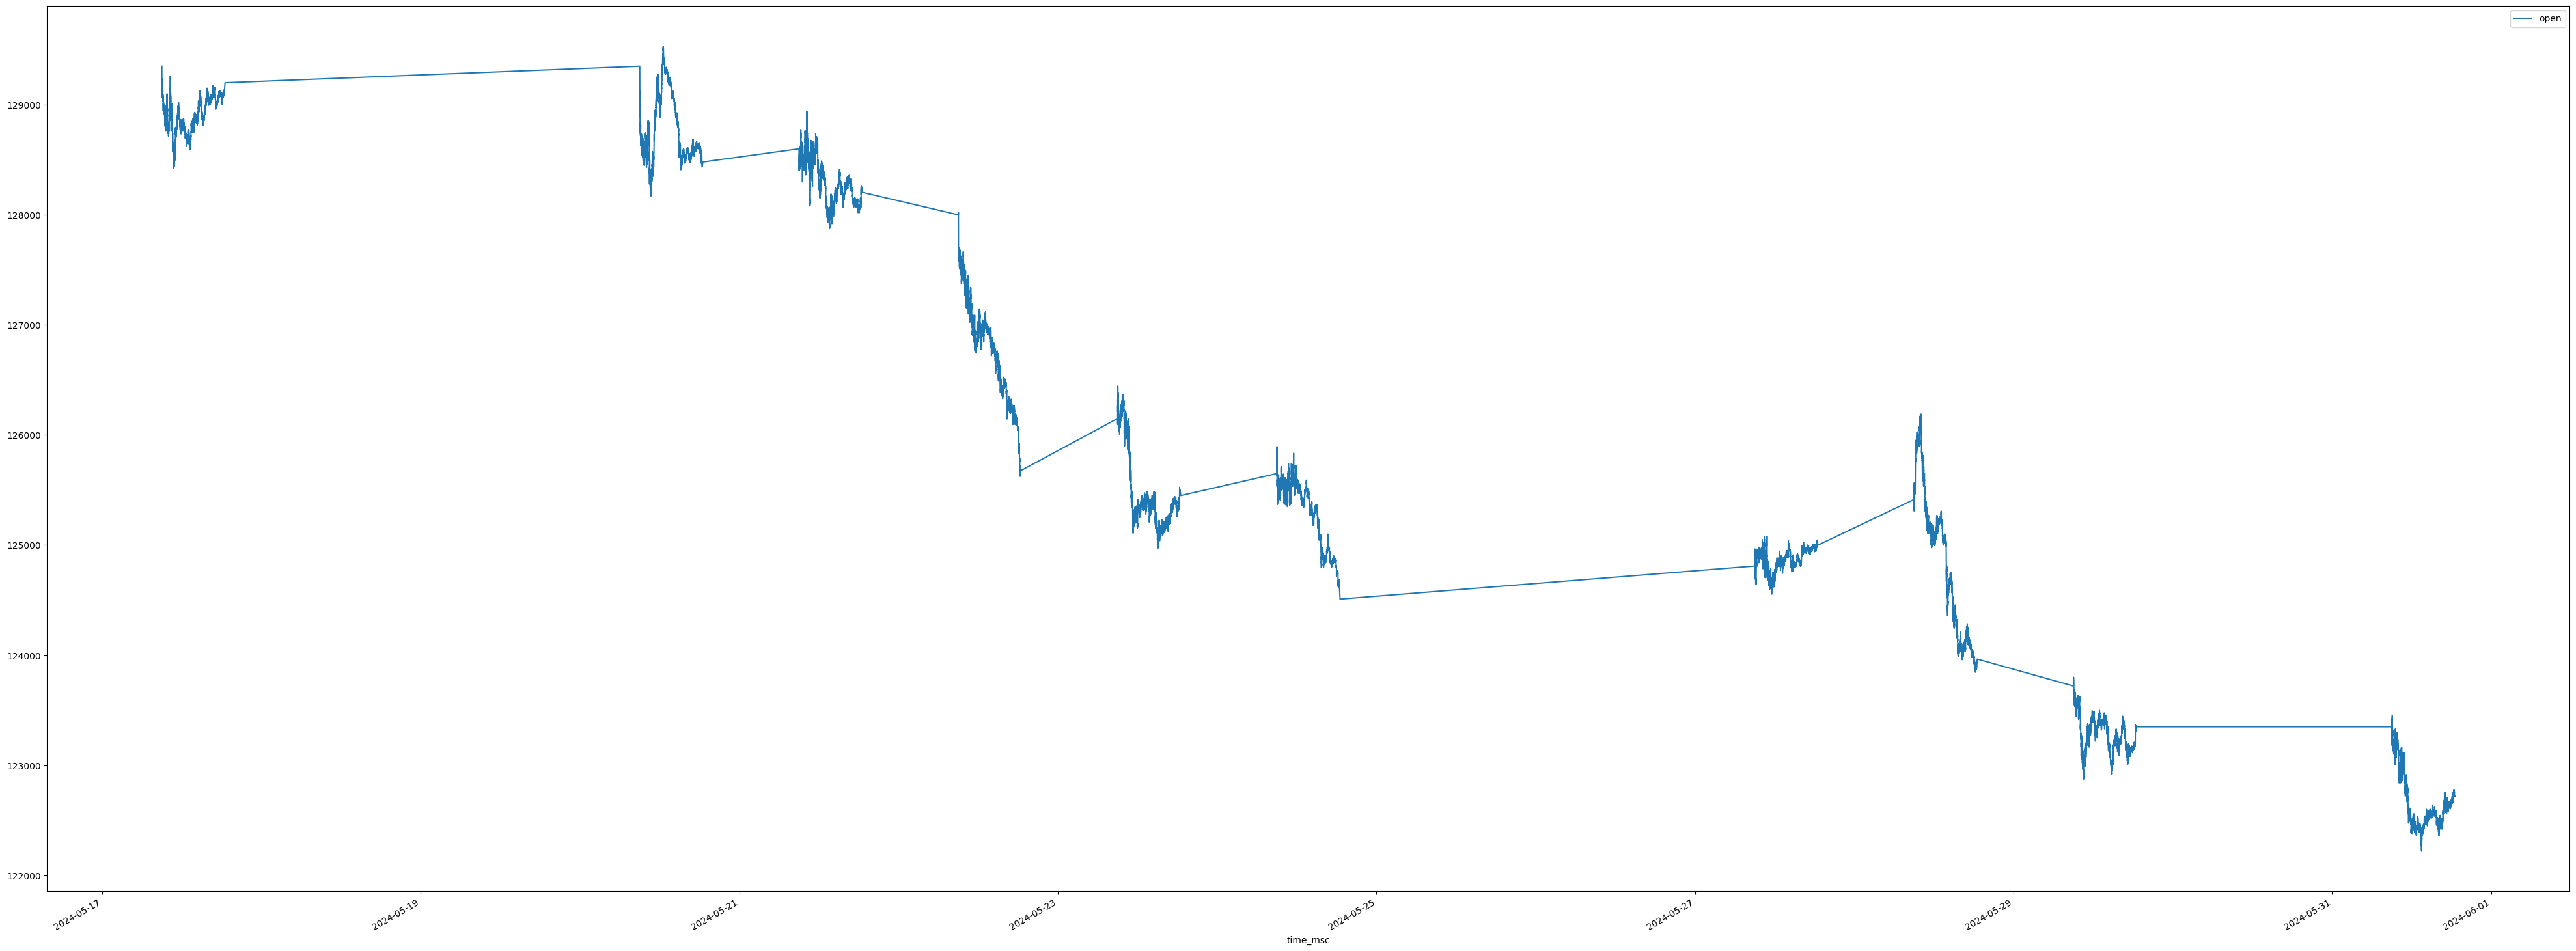

In [223]:
def format_rates(df):
    df.index = df.index.tz_localize(None)

    delta_to_score = lambda it: 1 if it == 0 else (2 if it > 0 else 3)

    df["sma"] = df.rolling(14)["open"].mean()
    df["current_delta"] = df["sma"] - df.shift(1)["sma"]
    df["forecast_delta"] = df.shift(-1)["sma"] - df["sma"]
    df["current_score"] = df["current_delta"].apply(delta_to_score)
    df["forecast_score"] = df["forecast_delta"].apply(delta_to_score)

    for c in df.columns:
        df[c] = df[c].apply(lambda it: it if it == it else 0)

    df = df.loc[df["open"] > 0]
    
    return df

def plot_rates(df, length):
    df.iloc[0:length][["open",]].plot(
        subplots=[("open",)],
        figsize=(50, 20),
    )

trainrates = format_rates(trainrates)
plot_rates(trainrates, length=None)

trainrates.corr()

In [106]:
#trainrates.to_excel("all_data.xlsx")

In [217]:
X = trainrates[["current_score"]]
Y = trainrates[["forecast_score"]]
best_features = SelectKBest(score_func=chi2, k=1)
fit = best_features.fit(X, Y)



In [87]:
df_scores= pd.DataFrame(fit.scores_)
df_columns= pd.DataFrame(X.columns)

features_scores= pd.concat([df_columns, df_scores], axis=1)
features_scores.columns= ['features', 'score']
features_scores.sort_values(by = 'score')


,features,score
2,low,529.811173
0,open,541.634559
3,close,547.004692
1,high,558.411245
5,current_score,4270.799103
4,sma,65108.883826


In [89]:
X= trainrates[["current_score", "sma"]]
Y= trainrates[["forecast_score"]]
best_features= SelectKBest(score_func=chi2, k=2)
fit= best_features.fit(X,Y)

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.40,random_state=100)

In [90]:
logreg= LogisticRegression(max_iter=10000)
logreg.fit(X_train,y_train["forecast_score"])

LogisticRegression(max_iter=10000)

In [91]:
y_pred=logreg.predict(X_test)
print (X_test) #test dataset
print (y_pred) #predicted values

                     current_score        sma
time_msc                                     
2024-05-28 09:22:35              2  125927.25
2024-05-21 14:29:55              3  128209.75
2024-05-20 11:03:55              3  128395.50
2024-05-21 11:37:10              2  128601.50
2024-05-29 11:57:15              3  123455.75
...                            ...        ...
2024-05-29 09:01:45              3       0.00
2024-05-28 13:19:50              3  125059.00
2024-05-29 11:21:45              3  123288.00
2024-05-22 11:35:10              3  126902.75
2024-05-20 15:05:55              2  128623.00

[27088 rows x 2 columns]
[3 3 3 ... 3 3 3]


In [94]:
print("CL Report: ", metrics.classification_report(y_test, y_pred, zero_division=1))

CL Report:                precision    recall  f1-score   support

           1       1.00      0.00      0.00      1696
           2       1.00      0.00      0.00     12304
           3       0.48      1.00      0.65     13088

    accuracy                           0.48     27088
   macro avg       0.83      0.33      0.22     27088
weighted avg       0.75      0.48      0.31     27088



In [79]:
from_date = datetime(2024, 6, 3, tzinfo=pytz.utc)
to_date = datetime(
    from_date.year, from_date.month, from_date.day, hour=23, tzinfo=pytz.utc
)
btrates = Mt5Helper.OHLC(mt5.copy_ticks_range("WINM24", from_date, to_date, mt5.COPY_TICKS_TRADE), "10s")

btrates = format_rates(btrates)

btrates

,open,high,low,close,tick_volume,real_volume,sma,current_delta,current_score,forecast_delta,forecast_score
time_msc,,,,,,,,,,,
2024-06-03 09:00:40,122860.0,122910.0,122840.0,122905.0,2726,11599,0.00,0.00,3,0.00,3
2024-06-03 09:00:50,122905.0,122920.0,122690.0,122695.0,8343,27297,0.00,0.00,3,0.00,3
2024-06-03 09:01:00,122700.0,122750.0,122665.0,122710.0,7907,20351,0.00,0.00,3,0.00,3
2024-06-03 09:01:10,122710.0,122760.0,122665.0,122760.0,4870,12328,0.00,0.00,3,0.00,3
2024-06-03 09:01:20,122755.0,122795.0,122700.0,122785.0,4688,11695,0.00,0.00,3,0.00,3
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03 18:24:20,122010.0,122015.0,122005.0,122015.0,31,165,122052.25,3.25,2,-2.75,3
2024-06-03 18:24:30,122015.0,122025.0,122010.0,122010.0,40,232,122049.50,2.75,2,-3.25,3
2024-06-03 18:24:40,122015.0,122015.0,122005.0,122010.0,27,130,122046.25,3.25,2,-3.25,3


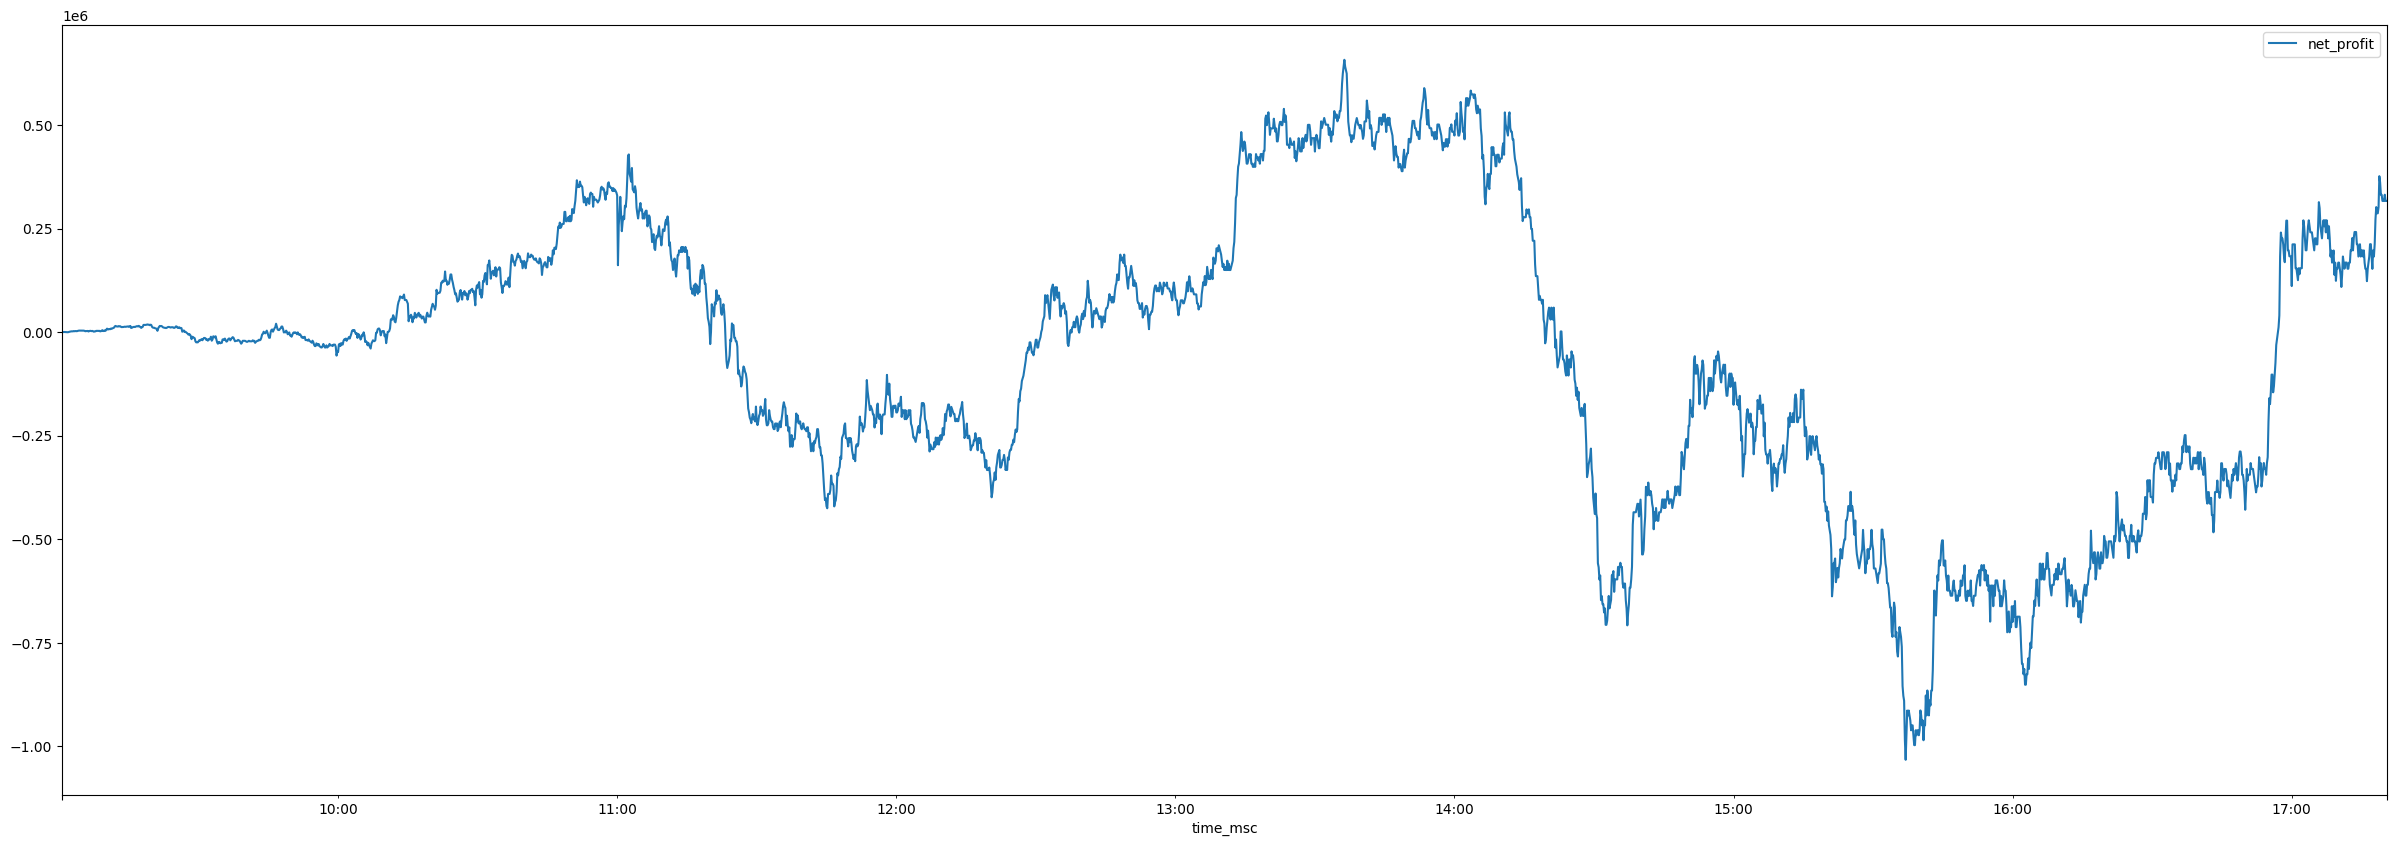

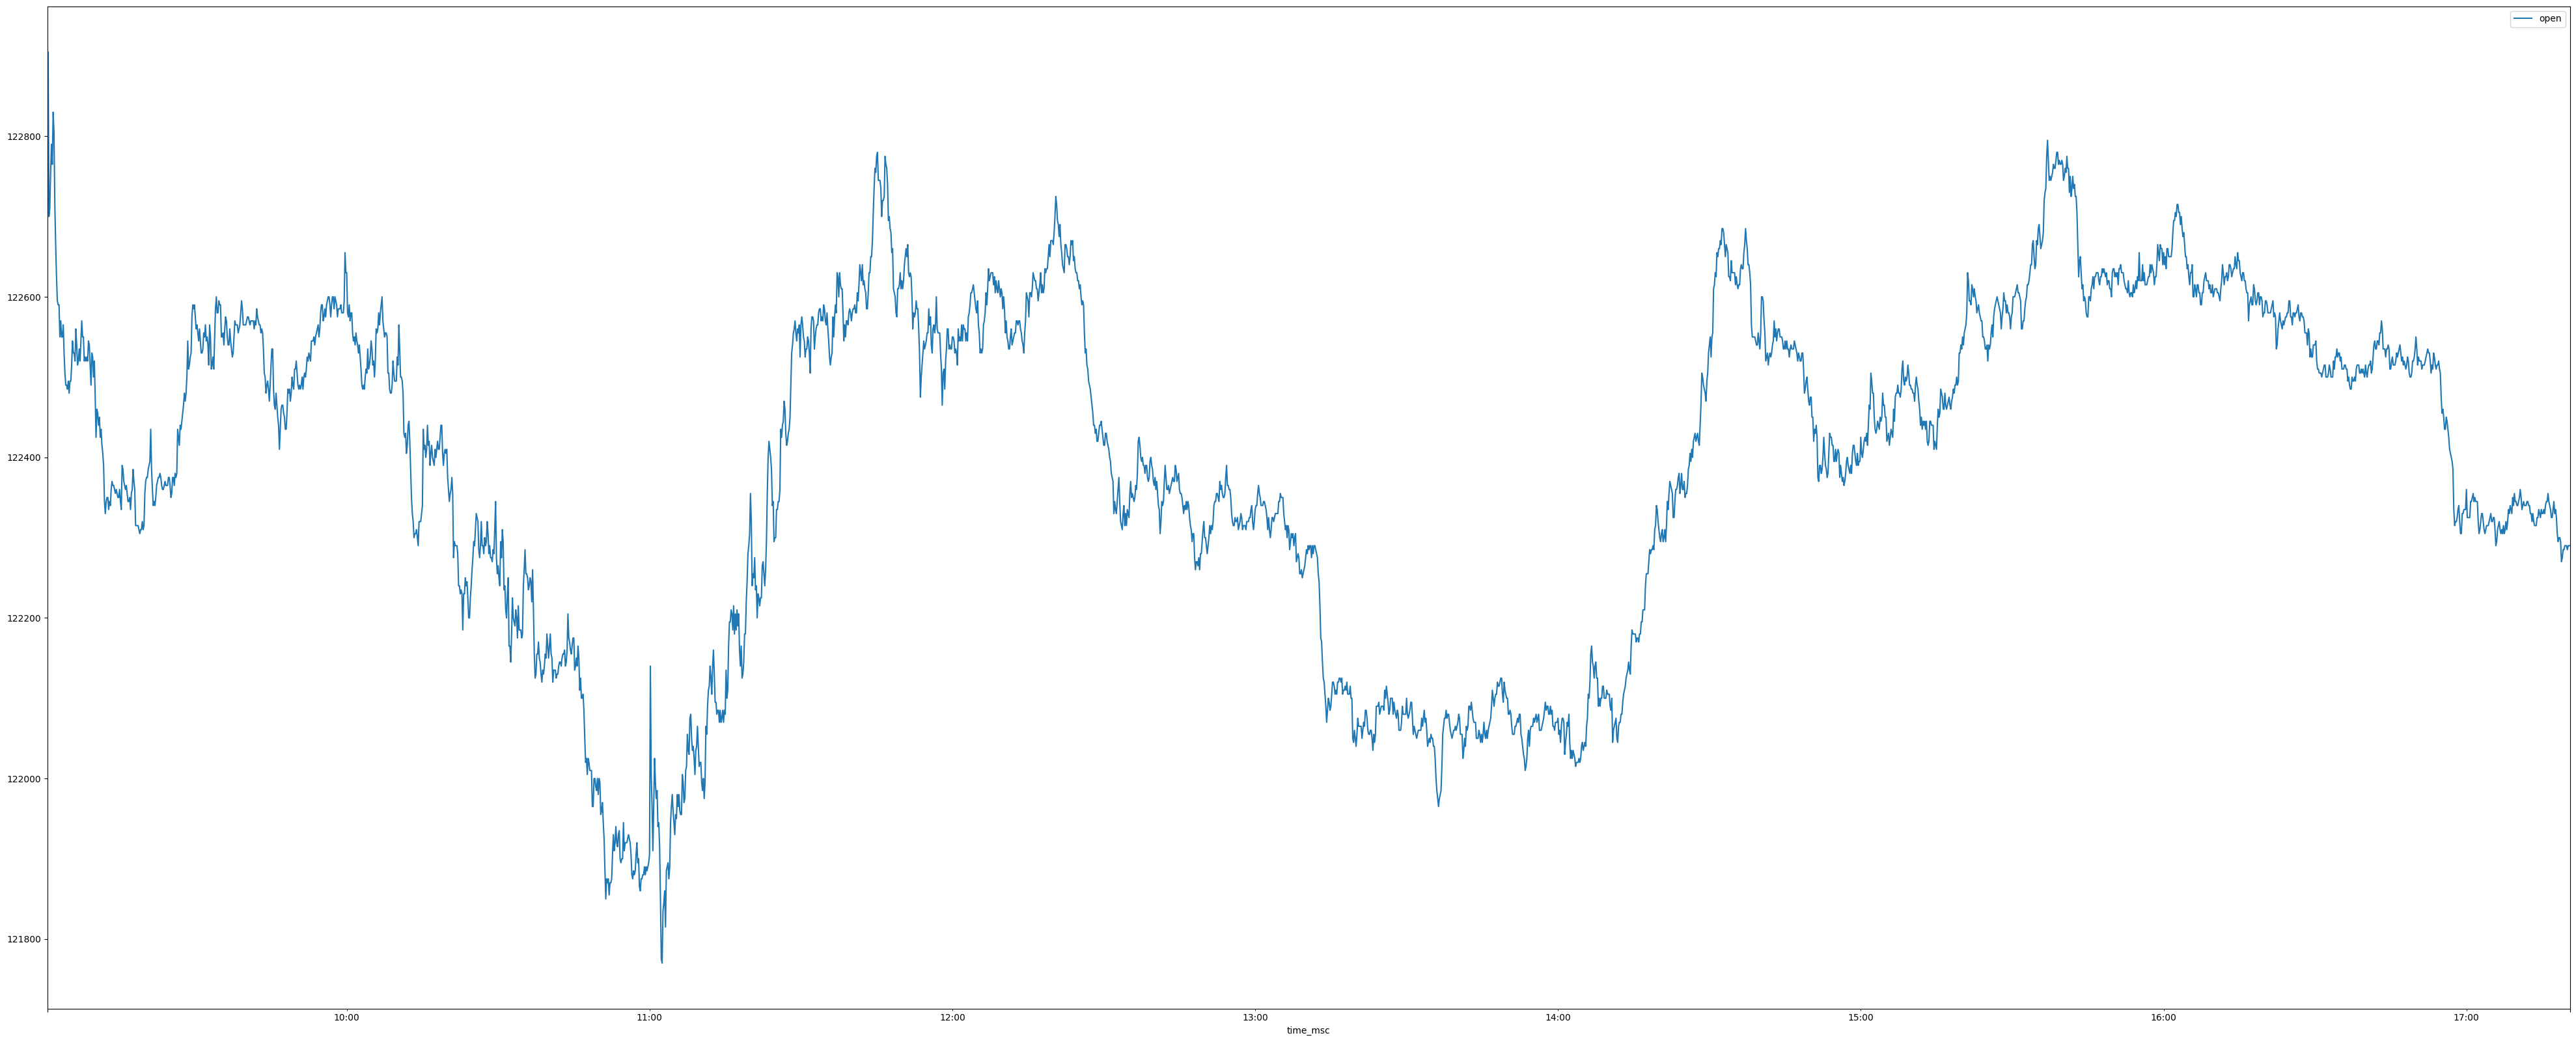

In [80]:
sum_buy = 0
buy_qty = 0
buy_avg = 0
buy_profit = 0

sum_sell = 0
sell_qty = 0
sell_avg = 0
sell_profit = 0

net_qty = 0
net_profit = 0

used_slippage = 0


def update(i):
    btrates.loc[i, "sum_buy"] = sum_buy
    btrates.loc[i, "buy_qty"] = buy_qty
    btrates.loc[i, "buy_avg"] = buy_avg
    btrates.loc[i, "buy_profit"] = buy_profit
    btrates.loc[i, "sum_sell"] = sum_sell
    btrates.loc[i, "sell_qty"] = sell_qty
    btrates.loc[i, "sell_avg"] = sell_avg
    btrates.loc[i, "sell_profit"] = sell_profit
    btrates.loc[i, "net_qty"] = net_qty
    btrates.loc[i, "net_profit"] = net_profit
    btrates.loc[i, "slippage"] = used_slippage

prev_i = None
for i, item in btrates.iterrows():
    if np.isnan(item.open):
        update(i)
        continue

    if prev_i is None: 
        prev_i = i
        continue

    used_slippage = slippage

    y_pred = logreg.predict(btrates[["close", "high", "current_score"]].loc[:prev_i])
    
    if y_pred[-1] == 2:
        qty = 1

        if net_qty < -2:
            qty = 2

        sum_buy += qty * (item.open + used_slippage)
        buy_qty += qty

    if y_pred[-1] == 3:
        qty = 1

        if net_qty > 2:
            qty = 2

        sum_sell += qty * (item.open - used_slippage)
        sell_qty += qty

    buy_avg = 0 if sum_buy == 0 else sum_buy / buy_qty
    sell_avg = 0 if sum_sell == 0 else sum_sell / sell_qty

    buy_profit = 0 if buy_qty == 0 else (item.open - used_slippage - buy_avg) * buy_qty
    sell_profit = (
        0 if sell_qty == 0 else (sell_avg - item.open + used_slippage) * sell_qty
    )

    net_qty = buy_qty - sell_qty
    net_profit = buy_profit + sell_profit

    update(i)
    
    prev_i = i

btrates.iloc[:3000][["net_profit"]].plot(figsize=(30, 10))

plot_rates(btrates, 3000)


In [ ]:
btrates.to_excel("output.xlsx")